<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/Makro_modell_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load CPI index (2015=100), filter out annual averages
cpi = pd.read_csv('08981_20250513-092551.csv', sep=';', skiprows=2, encoding='latin-1')
cpi = cpi[cpi['måned'] != 'Årsgjennomsnitt']  # drop yearly average rows
# Map month names to month number and construct date index
month_map = {"Januar":1,"Februar":2,"Mars":3,"April":4,"Mai":5,"Juni":6,
             "Juli":7,"August":8,"September":9,"Oktober":10,"November":11,"Desember":12}
cpi['month'] = cpi['måned'].map(month_map)
cpi['date'] = pd.to_datetime(cpi['år'].astype(str) + '-' + cpi['month'].astype(str) + '-01')
cpi = cpi[cpi['Konsumprisindeks (2015=100)'] != '.']  # remove missing values
cpi['CPI_index'] = pd.to_numeric(cpi['Konsumprisindeks (2015=100)'])
cpi.set_index('date', inplace=True)
cpi = cpi.sort_index()

# Load BNP (annual) and Lonn (annual)
BNP = pd.read_csv('09842_20250513-092607.csv', sep=';', skiprows=2, encoding='latin-1')
BNP = BNP.rename(columns={"Bruttonasjonalprodukt": "BNP"})
BNP['BNP'] = pd.to_numeric(BNP['BNP'])
BNP.index = pd.to_datetime(BNP['år'], format='%Y') + pd.offsets.YearEnd(0)  # use Dec 31 of each year as index
BNP = BNP['BNP']

Lonn = pd.read_csv('09174_20250513-092734.csv', sep=';', skiprows=2, encoding='latin-1')
Lonn = Lonn[Lonn['næring'] == 'Totalt for næringer'].rename(columns={"Lønn (mill. kr)": "Lonn"})
Lonn['Lonn'] = pd.to_numeric(Lonn['Lonn'])
Lonn.index = pd.to_datetime(Lonn['år'], format='%Y') + pd.offsets.YearEnd(0)
Lonn = Lonn['Lonn']

labor = pd.read_csv('08518_20250513-135649.csv', sep=';', skiprows=2, encoding='latin-1')
#Keep only the time identifier ('kvartal')
labor = labor[['kvartal', 'Arbeidsledige (prosent)']]
labor.columns = ['time', 'ledighet']


labor['time'] = labor['time'].str.replace('K', 'Q')
#    Create a PeriodIndex at quarterly frequency and convert to timestamp at end of quarter
labor['time'] = pd.PeriodIndex(labor['time'], freq='Q').to_timestamp(how='end')

# 5. Set the 'time' column as the index of the DataFrame
labor.set_index('time', inplace=True)
#    Normalize index to midnight to avoid fractional times
labor.index = labor.index.normalize()

# 6. Resample to monthly frequency and interpolate missing values linearly
labor_m = labor.resample('ME').interpolate(method='linear')

# 7. Ensure result is a pandas Series named 'ledighet'
labor_m = labor_m['ledighet']
labor_m.name = 'ledighet'

# Load oil price (assume monthly Brent price series fetched or provided)
oil = pd.read_csv('12462_20250513-123041.csv', sep=';', skiprows=2, encoding='latin-1')
# 2000M01  →  year = 2000, literal 'M', month = 01
oil['date'] = (
    pd.to_datetime(oil['måned'], format='%YM%m')      # parse to 2000-01-01
    + pd.offsets.MonthEnd(0))
oil = oil.rename(columns={"Produsentprisindeks (2021=100)": "Price"})
oil['Price'] = pd.to_numeric(oil['Price'])
oil = oil.set_index('date').sort_index()

In [3]:
# norges bank rente
url = 'https://data.norges-bank.no/api/data/IR/A.KPRA.SD.?format=csv&startPeriod=1995-05-12&endPeriod=2025-05-12&locale=no&bom=include'

rente = pd.read_csv(url,
    sep=';',
    parse_dates=['TIME_PERIOD'],
    decimal='.' )
rente = rente.rename(columns={"TIME_PERIOD": "date",
                        "OBS_VALUE":   "rate"})
rente.set_index("date", inplace=True)


# keep only date and rate

rente = rente[["rate"]]

# numeric, swap , with .

rente['rate'] = rente['rate'].str.replace(',', '.')
rente['rate'] = pd.to_numeric(rente['rate'])


In [4]:
# Resample BNP and Lonn to monthly frequency via linear interpolation
BNP_monthly = BNP.resample('ME').interpolate(method='linear')
Lonn_monthly = Lonn.resample('ME').interpolate(method='linear')

In [5]:
# BNP_monthly in percentage growth
BNP_monthly = BNP_monthly.pct_change() * 100
Lonn_monthly = Lonn_monthly.pct_change() * 100

In [6]:
# Assemble a DataFrame of all variables at monthly frequency
df = pd.DataFrame({
    'CPI_index': cpi['CPI_index'],
    'BNP': BNP_monthly,
    'Lonn': Lonn_monthly,
    'ledighet': labor_m,
    'olje_indeks': oil['Price'],
    'rente': rente['rate'], # assume oil DataFrame with 'Price'
}).ffill()  # forward-fill any starting NaNs if needed

In [7]:
df = df[df.index > '2000-01-01'] # for nyere data + oljeprisindeks starter år 2000

In [8]:
# Compute monthly percent changes for all series
df_pct = df
# Drop the first month (no previous month to compare)
df_pct = df_pct.dropna(subset=['CPI_index'])

# Define the target (inflation) and predictor variables
df_pct.rename(columns={'CPI_index': 'Inflation'}, inplace=True)
y = df_pct['Inflation']#.iloc[1:]          # prosentvis cpi, må ta bort 1 for lik lengde på x og y
#X = df_pct[['BNP','Lonn','ledighet','rente']]
X = df_pct[['BNP','Lonn','ledighet','olje_indeks', 'rente']].dropna()

In [9]:
#df_pct = df_pct[df_pct.index > '1996-01-01']

In [10]:
import statsmodels.api as sm
# X and y are the same DataFrame / Series you used before
X_const = sm.add_constant(X)         # adds an intercept term
ols_model = sm.OLS(y, X_const).fit()  # fit ordinary least squares

print(ols_model.summary())            # full table: coef, std err, t, P>|t|, etc.

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     445.2
Date:                Wed, 14 May 2025   Prob (F-statistic):          2.29e-199
Time:                        16:34:22   Log-Likelihood:                -2097.8
No. Observations:                 607   AIC:                             4208.
Df Residuals:                     601   BIC:                             4234.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.9663      3.568     12.881      

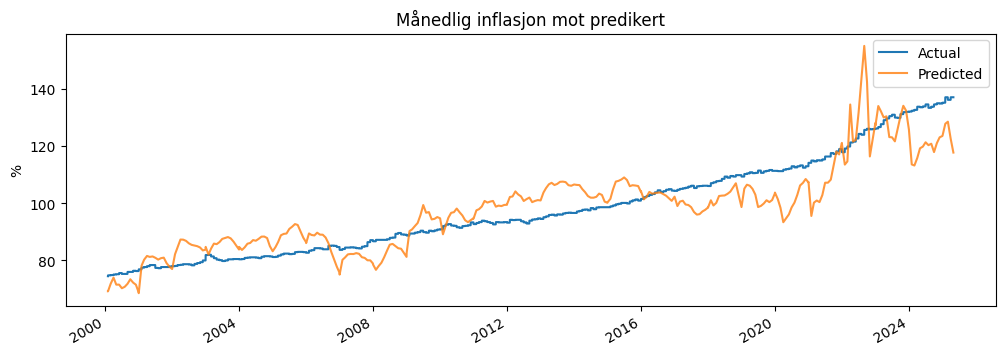

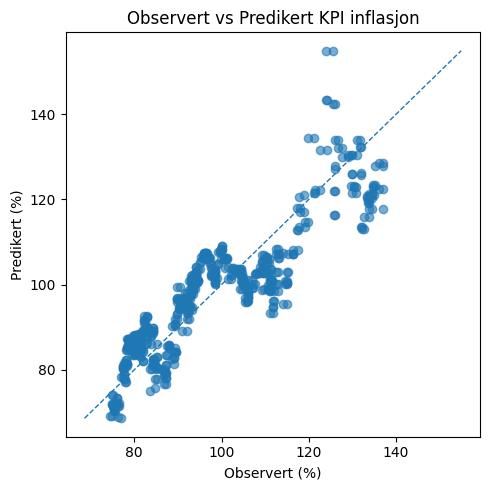

In [11]:
import matplotlib.pyplot as plt

y_pred = ols_model.predict(X_const) # pandas

# actual vs predicted over time
ax = y.plot(label='Actual', figsize=(12, 4))
y_pred.plot(ax=ax, label='Predicted', alpha=0.8)
ax.set_title('Månedlig inflasjon mot predikert')
ax.set_ylabel('%')
ax.legend()
plt.show()

# scatter med 45-graders
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, alpha=0.6)
lim = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(lim, lim, '--', lw=1)
plt.xlabel('Observert (%)')
plt.ylabel('Predikert (%)')
plt.title('Observert vs Predikert KPI inflasjon')
plt.tight_layout()
plt.show()

## Med lagged inflation

In [12]:
# likt som forrgie df, med lagged, bruker samme kode
df_pct_t = df
# Drop the first month
df_pct_t = df_pct_t.dropna(subset=['CPI_index'])

# Define the target (inflation) and predictor variables
df_pct_t.rename(columns={'CPI_index': 'Inflation'}, inplace=True)
df_pct_t['Infl_lag1'] = df_pct_t['Inflation'].shift(1).dropna()
y_t = df_pct_t['Inflation'].iloc[1:]
X_t = df_pct_t[['Infl_lag1','BNP','Lonn','ledighet','olje_indeks', 'rente']].dropna()

In [13]:
X_const_t = sm.add_constant(X_t)         # adds an intercept term
ols_model_t = sm.OLS(y_t, X_const_t).fit()  # fit ordinary least squares

print(ols_model_t.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.195e+05
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        16:34:22   Log-Likelihood:                -231.15
No. Observations:                 606   AIC:                             476.3
Df Residuals:                     599   BIC:                             507.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1333      0.187     -0.714      

## Kilde:

OpenAI. (2023). ChatGPT (14. mai versjon) [O3]. https://chat.openai.com/